In [2]:
!pip install evaluate datasets bert_score

Using device: cuda
Loading medical dataset...
Total training samples: 20296
Total test samples: 5075
Sampled 2000 training and 400 test instances
Average question length: 301.42 characters
Average reasoning length: 1890.90 characters
Average response length: 639.79 characters

Example medical queries and responses:

Example 1:
Question: By international agreement, low birth weight has been defined as a birth weight when measured within the first hour of life is
A. Less than 2000 grams
B. Less than 2800 grams
C. Less than 2500 grams
D. Less than 3000 grams
Reasoning: Okay, so I need to figure out what counts as a low birth weight for newborns. Let's see, there's a specific weight threshold that's internationally agreed upon for this. I'm pretty sure I've seen this defined somewhere before. Oh, right, I remember that the World Health Organization has its say in t...
Response: By international agreement, low birth weight is defined as a birth weight of less than 2500 grams when measured w

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Fine-tuned Model Evaluation Results:
Average BERTScore Precision: 0.8109
Average BERTScore Recall: 0.8603
Average BERTScore F1: 0.8346

Example Predictions:
--------------------------------------------------------------------------------
Question: A 7-year-old boy presents to the outpatient department with a painless limp. On examination, you not...
Generated: Reasoning: Alright, let's think this through. We have a 7-year-old boy who has a painless limp. That's a bit unusual. Hmm, it's interesting because th...
Reference: Based on the clinical findings you've described—a 7-year-old boy with a painless limp, restricted abduction and internal rotation of the left hip, and...
BERTScore F1: 0.8449
--------------------------------------------------------------------------------
Question: Who is credited with recognizing the distinction between general and particular jurisprudence?...
Generated: Reasoning: Alright, let's think this through. General jurisprudence, right? It's all about the b

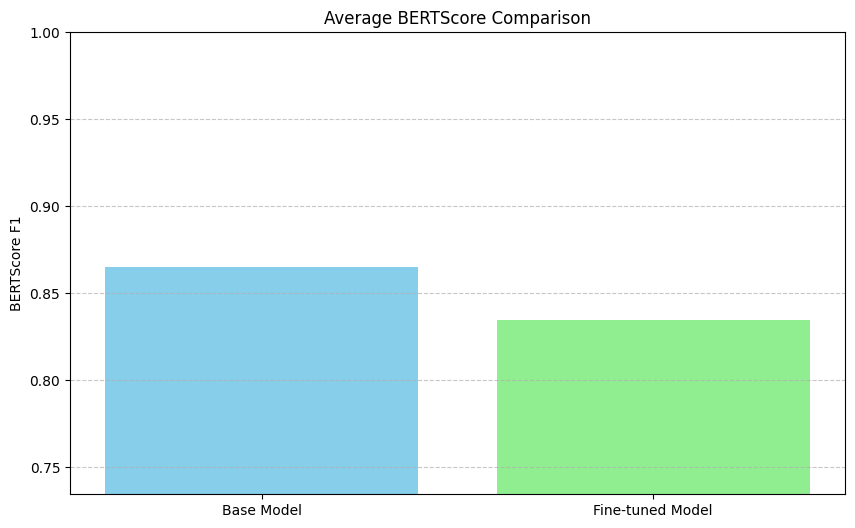

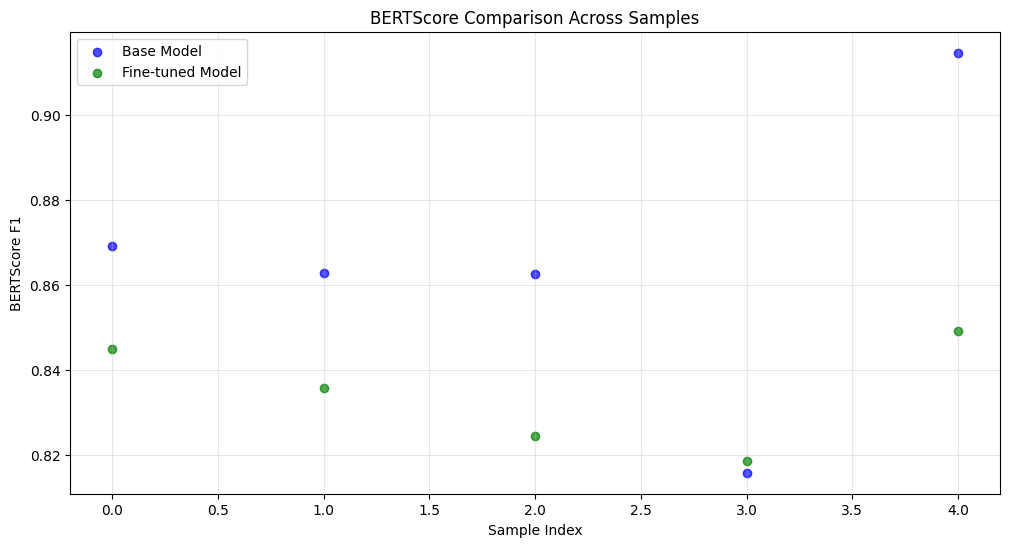

In [7]:
"""
Fine-Tuning a Language Model: Health Advisor Chatbot

Using Medical-o1-reasoning-SFT dataset from FreedomIntelligence,
this dataset not only includes question/response, but a third column
showing the model's complex chain of thought, allowing for better
medical analysis training.

25,400 rows of data.

=================================================
"""

import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM, # for causal instead of classification
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorForLanguageModeling # also added for causal language modeling
)
from datasets import load_dataset
from evaluate import load # For BERTScore evaluation
import torch.nn.functional as F
import seaborn as sns
import re
import random

# Force garbage collection
gc.collect()

# Clear GPU cache
torch.cuda.empty_cache()

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define paths
BASE_MODEL = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"  # using TinyLlama due to it's similarity to GPT-3.5 while being open-source and small
OUTPUT_DIR = "./health_advisor_model"
os.makedirs(OUTPUT_DIR, exist_ok=True)

#################################################
# PART 1: LOADING THE MEDICAL DATASET
#################################################

def load_medical_dataset(max_samples=None):
    """
    Load the medical dataset using the Hugging Face datasets library.
    """
    print("Loading medical dataset...")

    # Load the dataset
    medical_dataset = load_dataset("FreedomIntelligence/medical-o1-reasoning-SFT", "en")

    # Convert to pandas DataFrames
    train_df = pd.DataFrame(medical_dataset["train"])

    # Split train into train and test
    train_size = int(0.8 * len(train_df))
    train_df, test_df = train_df.iloc[:train_size], train_df.iloc[train_size:]
    train_df = train_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    # Print dataset information
    print(f"Total training samples: {len(train_df)}")
    print(f"Total test samples: {len(test_df)}")

    # If max_samples is specified, sample the data
    if max_samples and max_samples < len(train_df):
        train_df = train_df.sample(max_samples, random_state=42)
        test_df = test_df.sample(max_samples // 5, random_state=42)
        print(f"Sampled {len(train_df)} training and {len(test_df)} test instances")

    # Add text length statistics
    train_df['question_length'] = train_df['Question'].apply(lambda x: len(str(x)))
    train_df['cot_length'] = train_df['Complex_CoT'].apply(lambda x: len(str(x)))
    train_df['response_length'] = train_df['Response'].apply(lambda x: len(str(x)))

    print(f"Average question length: {train_df['question_length'].mean():.2f} characters")
    print(f"Average reasoning length: {train_df['cot_length'].mean():.2f} characters")
    print(f"Average response length: {train_df['response_length'].mean():.2f} characters")

    # Show a few examples
    print("\nExample medical queries and responses:")
    for i in range(min(3, len(train_df))):
        question = str(train_df.iloc[i]['Question'])
        reasoning = str(train_df.iloc[i]['Complex_CoT'])
        response = str(train_df.iloc[i]['Response'])

        print(f"\nExample {i+1}:")
        print(f"Question: {question[:300]}..." if len(question) > 300 else f"Question: {question}")
        print(f"Reasoning: {reasoning[:300]}..." if len(reasoning) > 300 else f"Reasoning: {reasoning}")
        print(f"Response: {response[:300]}..." if len(response) > 300 else f"Response: {response}")

    return train_df, test_df

# Load the dataset
train_df, test_df = load_medical_dataset(max_samples=2000)

# Clean the dataset
def clean_text(text):
    text = str(text)  # Ensure text is a string
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text).strip()  # Remove excessive whitespace
    return text

# Apply cleaning to all text columns
train_df['Question'] = train_df['Question'].apply(clean_text)
train_df['Complex_CoT'] = train_df['Complex_CoT'].apply(clean_text)
train_df['Response'] = train_df['Response'].apply(clean_text)
test_df['Question'] = test_df['Question'].apply(clean_text)
test_df['Complex_CoT'] = test_df['Complex_CoT'].apply(clean_text)
test_df['Response'] = test_df['Response'].apply(clean_text)

#################################################
# PART 2: PREPARING THE DATA
#################################################

class MedicalAdviceDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=1024):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

        # Configure tokenizer for padding
        self.tokenizer.pad_token = self.tokenizer.eos_token

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get data for this item
        question = str(self.dataframe.iloc[idx]['Question'])
        cot = str(self.dataframe.iloc[idx]['Complex_CoT'])
        response = str(self.dataframe.iloc[idx]['Response'])

        # Format as instruction with CoT and response
        instruction = question
        output = f"Reasoning: {cot}\n\nAnswer: {response}"

        # Format according to TinyLlama's expected instruction format
        prompt = f"<|user|>\n{instruction}\n<|assistant|>\n{output}"

        # Tokenize the formatted text
        encoding = self.tokenizer(
            prompt,
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt",
            add_special_tokens=True  # Let the tokenizer handle special tokens
        )

        # Create the labels (same as input_ids, for causal language modeling)
        labels = encoding["input_ids"].clone()

        # Find the position where the output starts
        input_part = self.tokenizer(f"[INST] {instruction} [/INST] ", add_special_tokens=False)
        input_length = len(input_part["input_ids"])

        # Create the labels (same as input_ids, for causal language modeling)
        labels = encoding["input_ids"].clone()

        # Find the position where the assistant's response starts
        input_part = self.tokenizer(f"<|user|>\n{instruction}\n<|assistant|>\n", add_special_tokens=False)
        input_length = len(input_part["input_ids"])

        # Set labels for the input part to -100 (ignore in loss)
        labels[0, :input_length] = -100

        # Create return dictionary
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": labels.flatten()
        }

# Load the tokenizer
print(f"Loading tokenizer: {BASE_MODEL}")
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)

# Create datasets
print("Creating datasets...")
train_dataset = MedicalAdviceDataset(
    train_df,
    tokenizer
)

test_dataset = MedicalAdviceDataset(
    test_df,
    tokenizer
)

# Split training data to create a validation set
print("Creating validation split...")
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# Check an example to verify formatting
example_idx = 0
example = train_dataset[example_idx]

# Decode only the meaningful part, skipping repeated EOS tokens
meaningful_ids = example["input_ids"][example["attention_mask"].bool()]
decoded_text = tokenizer.decode(meaningful_ids, skip_special_tokens=False)

print("\nExample formatted text:")
print("-" * 40)
print(decoded_text)
print("-" * 40)

#################################################
# PART 3: EVALUATE BASE MODEL (SHOWING LIMITATIONS)
#################################################

def generate_response(model, tokenizer, question, max_new_tokens=512):
    """
    Generate a response from the model for a given question.
    """
    # Format the input as per TinyLlama's instruction format
    prompt = f"<|user|>\n{question}\n<|assistant|>"

    # Tokenize the input
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    # Generate the output
    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=max_new_tokens,
            temperature=0.7,
            do_sample=True,
            top_p=0.9,
            pad_token_id=tokenizer.eos_token_id
        )

    # Decode the output
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract just the response part (after <|assistant|>)
    response_start = generated_text.find("<|assistant|>")
    if response_start != -1:
        response = generated_text[response_start + len("<|assistant|>"):].strip()
    else:
        response = generated_text.strip()

    return response

def evaluate_model_generative(model, tokenizer, dataset, num_samples=10, model_name="Base Model"):
    """
    Evaluate the model on a sample of questions and compare to reference answers.
    """
    bertscore = load("bertscore")

    print(f"\nEvaluating {model_name} on {num_samples} samples...")

    questions = []
    generated_responses = []
    reference_responses = []
    reasoning_references = []

    # Select random samples for evaluation
    indices = torch.randperm(len(dataset))[:num_samples].tolist()

    for idx in indices:
        # Get a sample
        sample = dataset[idx]

        # Get the original text components
        sample_text = tokenizer.decode(sample["input_ids"], skip_special_tokens=True)

        # Extract question (between <|user|> and <|assistant|>)
        user_start = sample_text.find("<|user|>") + len("<|user|>")
        assistant_start = sample_text.find("<|assistant|>")
        question = sample_text[user_start:assistant_start].strip()

        # Extract reference response
        sample_text_after_assistant = sample_text[assistant_start + len("<|assistant|>"):].strip()
        reasoning_start = sample_text_after_assistant.find("Reasoning:") + len("Reasoning:")
        answer_start = sample_text_after_assistant.find("Answer:") + len("Answer:")

        reasoning_ref = sample_text_after_assistant[reasoning_start:answer_start].strip()
        response_ref = sample_text_after_assistant[answer_start:].strip()

        # Generate a response with the model
        generated = generate_response(model, tokenizer, question)

        questions.append(question)
        generated_responses.append(generated)
        reference_responses.append(response_ref)
        reasoning_references.append(reasoning_ref)

    # Calculate BERTScore for generated responses against references
    bertscore_results = bertscore.compute(
        predictions=generated_responses,
        references=reference_responses,
        lang="en"
    )

    # Calculate average scores
    avg_precision = sum(bertscore_results['precision']) / len(bertscore_results['precision'])
    avg_recall = sum(bertscore_results['recall']) / len(bertscore_results['recall'])
    avg_f1 = sum(bertscore_results['f1']) / len(bertscore_results['f1'])

    print(f"\n{model_name} Evaluation Results:")
    print(f"Average BERTScore Precision: {avg_precision:.4f}")
    print(f"Average BERTScore Recall: {avg_recall:.4f}")
    print(f"Average BERTScore F1: {avg_f1:.4f}")

    # Show example predictions
    print("\nExample Predictions:")
    print("-" * 80)

    for i in range(min(3, len(questions))):
        print(f"Question: {questions[i][:100]}...")
        print(f"Generated: {generated_responses[i][:150]}...")
        print(f"Reference: {reference_responses[i][:150]}...")
        print(f"BERTScore F1: {bertscore_results['f1'][i]:.4f}")
        print("-" * 80)

    return {
        'bertscore_precision': avg_precision,
        'bertscore_recall': avg_recall,
        'bertscore_f1': avg_f1,
        'examples': {
            'questions': questions,
            'generated': generated_responses,
            'references': reference_responses,
            'reasoning_refs': reasoning_references,
            'scores': bertscore_results
        }
    }

# Load base model with additional parameters for memory efficiency
print(f"Loading base model: {BASE_MODEL}")
base_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    low_cpu_mem_usage=True,
    offload_state_dict=True,  # This helps with memory issues
    device_map="auto"
)
base_model.eval()  # Set to evaluation mode

# Evaluate base model

base_results = evaluate_model_generative(
    base_model,
    tokenizer,
    test_dataset,
    num_samples=5,  # Using a small number for demonstration
    model_name="Base Model"
)

#################################################
# PART 4: FINE-TUNING THE MODEL
#################################################


def fine_tune_model(model, train_dataset, val_dataset, tokenizer):

    #Fine-tune the model on our medical dataset.

    # Define training arguments
    print("\nSetting up fine-tuning...")
    training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=3,                  # Reduced to 2 epochs for testing
    per_device_train_batch_size=4,       # Batch size for training
    per_device_eval_batch_size=4,        # Batch size for evaluation
    gradient_accumulation_steps=2,
    learning_rate=5e-6,
    warmup_ratio=0.1,                    # Reduced warmup steps
    weight_decay=0.05,                   # Strength of weight decay
    logging_dir='./logs',                # Directory for storing logs
    logging_steps=10,                    # Increased logging frequency for testing
    evaluation_strategy="steps",         # Evaluate during training
    eval_steps=50,                      # Evaluate every 200 steps
    save_strategy="steps",               # Save checkpoint during training
    save_steps=50,                      # Save checkpoint every 200 steps
    save_total_limit=3,                  # Only save the 3 best checkpoints
    load_best_model_at_end=True,         # Load the best model at the end
    metric_for_best_model="eval_loss",   # Use loss for determining best model
    fp16=False,
    bf16=False,
    report_to="none"
    )

    # Create a data collator that handles padding
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False                            # Not using masked language modeling
    )

    # Create Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=data_collator,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
    )

    # Train the model
    print("Starting test fine-tuning process...")
    trainer.train()

    # Save the model
    print("Saving fine-tuned test model...")
    trainer.save_model(OUTPUT_DIR)
    tokenizer.save_pretrained(OUTPUT_DIR)

    return trainer.model

# Create a copy of the base model for fine-tuning
print("\nPreparing model for test fine-tuning...")
fine_tuned_model = AutoModelForCausalLM.from_pretrained(
    BASE_MODEL,
    torch_dtype=torch.float32,
)

# Freeze the bottom 70% of the layers
print("Freezing bottom layers of the model...")
# For transformer models, layers are typically organized in a list
modules = list(fine_tuned_model.named_modules())
transformer_layers = [name for name, _ in modules if "layers" in name and "block" in name]
num_layers = len(transformer_layers)
num_to_freeze = int(0.7 * num_layers)  # Freeze 70% of layers

# Freeze parameters of the bottom layers
for name, param in fine_tuned_model.named_parameters():
    if any(layer_name in name for layer_name in transformer_layers[:num_to_freeze]):
        param.requires_grad = False

# Then explicitly move to device
fine_tuned_model = fine_tuned_model.to(device)

# Use a reasonable portion of the dataset (not too small, not too large)
# For TinyLlama, ~1000-2000 examples should provide good results
print("\nPreparing training and validation datasets...")

# If the full dataset is too large, sample a subset
if len(train_dataset) > 2000:
    train_indices = torch.randperm(len(train_dataset))[:2000].tolist()
    sampled_train_dataset = torch.utils.data.Subset(train_dataset, train_indices)
    print(f"Sampled {len(sampled_train_dataset)} examples from {len(train_dataset)} for training")
else:
    sampled_train_dataset = train_dataset
    print(f"Using all {len(sampled_train_dataset)} examples for training")

# Create validation dataset
if len(val_dataset) > 200:
    val_indices = torch.randperm(len(val_dataset))[:200].tolist()
    sampled_val_dataset = torch.utils.data.Subset(val_dataset, val_indices)
    print(f"Sampled {len(sampled_val_dataset)} examples from {len(val_dataset)} for validation")
else:
    sampled_val_dataset = val_dataset
    print(f"Using all {len(sampled_val_dataset)} examples for validation")

# Fine-tune the model
fine_tuned_model = fine_tune_model(fine_tuned_model, sampled_train_dataset, sampled_val_dataset, tokenizer)

#################################################
# PART 5: EVALUATE FINE-TUNED MODEL
#################################################


# Load the fine-tuned model
print("\nLoading fine-tuned model...")
fine_tuned_model = AutoModelForCausalLM.from_pretrained(
    OUTPUT_DIR,
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    low_cpu_mem_usage=True,
    device_map="auto"
)
fine_tuned_model.eval()  # Set to evaluation mode

# Evaluate fine-tuned model using the same function we used for the base model
tuned_results = evaluate_model_generative(
    fine_tuned_model,
    tokenizer,
    test_dataset,
    num_samples=5,  # Using more samples for a better comparison
    model_name="Fine-tuned Model"
)

#################################################
# PART 6: COMPARING RESULTS
#################################################

# Compare performances
base_bertscore = base_results['bertscore_f1']
tuned_bertscore = tuned_results['bertscore_f1']
improvement = (tuned_bertscore - base_bertscore) * 100

print("\n" + "="*50)
print("COMPARISON OF MODEL PERFORMANCE")
print("="*50)
print(f"Base Model BERTScore F1: {base_bertscore:.4f}")
print(f"Fine-tuned Model BERTScore F1: {tuned_bertscore:.4f}")
print(f"Absolute Improvement: {improvement:.2f}%")
if base_bertscore > 0:
    relative_improvement = (improvement / base_bertscore) * 100
    print(f"Relative Improvement: {relative_improvement:.2f}%")
print("="*50)

# Show example predictions side by side
print("\nExample Predictions:")
print("-"*100)
print(f"{'Question':<30} | {'Base Model Response':<35} | {'Fine-tuned Response':<35}")
print("-"*100)

# Get samples from both model evaluations
# Find common questions between both evaluations
base_questions = base_results['examples']['questions']
tuned_questions = tuned_results['examples']['questions']

# Get a few examples to show
num_examples = min(3, len(base_questions), len(tuned_questions))

for i in range(num_examples):
    question = base_questions[i]
    if len(question) > 27:
        question = question[:27] + "..."

    base_resp = base_results['examples']['generated'][i]
    if len(base_resp) > 32:
        base_resp = base_resp[:32] + "..."

    tuned_resp = tuned_results['examples']['generated'][i]
    if len(tuned_resp) > 32:
        tuned_resp = tuned_resp[:32] + "..."

    print(f"{question:<30} | {base_resp:<35} | {tuned_resp:<35}")

# Generate a more detailed comparison for one example
print("\n" + "="*50)
print("DETAILED COMPARISON OF ONE EXAMPLE")
print("="*50)

# Choose an interesting example
example_idx = 0  # Can be changed to any other index

print(f"Question:\n{base_questions[example_idx]}\n")
print(f"Base Model Response:\n{base_results['examples']['generated'][example_idx][:500]}...\n")
print(f"Fine-tuned Model Response:\n{tuned_results['examples']['generated'][example_idx][:500]}...\n")
print(f"Reference Response:\n{base_results['examples']['references'][example_idx][:500]}...\n")

print(f"Base Model BERTScore: {base_results['examples']['scores']['f1'][example_idx]:.4f}")
print(f"Fine-tuned Model BERTScore: {tuned_results['examples']['scores']['f1'][example_idx]:.4f}")

# Create a visualization comparing BERTScores
scores_base = [score for score in base_results['examples']['scores']['f1']]
scores_tuned = [score for score in tuned_results['examples']['scores']['f1']]

plt.figure(figsize=(10, 6))
plt.bar(
    ['Base Model', 'Fine-tuned Model'],
    [base_bertscore, tuned_bertscore],
    color=['skyblue', 'lightgreen']
)
plt.title('Average BERTScore Comparison')
plt.ylabel('BERTScore F1')
plt.ylim(min(base_bertscore, tuned_bertscore) - 0.1, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('model_comparison.png')

# Create a plot showing all sample scores
plt.figure(figsize=(12, 6))
plt.scatter(range(len(scores_base)), scores_base, label='Base Model', color='blue', alpha=0.7)
plt.scatter(range(len(scores_tuned)), scores_tuned, label='Fine-tuned Model', color='green', alpha=0.7)
plt.title('BERTScore Comparison Across Samples')
plt.xlabel('Sample Index')
plt.ylabel('BERTScore F1')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('sample_comparison.png')

print("\nVisualization saved as 'model_comparison.png' and 'sample_comparison.png'")